In [1]:
import pandas as pd

true_df = pd.read_csv('True.csv') #21417개
fake_df = pd.read_csv('Fake.csv') #23481개

In [2]:
#결측값 제거함수
fake_df = fake_df.dropna(subset=['title', 'text'], how='all')
true_df = true_df.dropna(subset=['title', 'text'], how='all')

true_df['label'] = 1
fake_df['label'] = 0
#true_df에 맞게 데이터 개수 조절하여 데이터 불균형 해소
filtered_fake_df = fake_df.sample(n = 21417, random_state=42)
#데이터 결합
totalnews_df = pd.concat([true_df, filtered_fake_df]).reset_index(drop=True)


In [3]:
#결측값 확인 함수 --> 현재 데이터셋은 결측값 X
print(totalnews_df.isnull().sum())

title      0
text       0
subject    0
date       0
label      0
dtype: int64


In [4]:
# 최종 수정 코드
import re
from bs4 import BeautifulSoup
from tqdm import tqdm

# 전처리 함수 (모든 오류 수정 버전)
def process_text(text):
    # 1. HTML 태그 제거
    text = BeautifulSoup(text, "html.parser").get_text()   
    # 4. 공백 정리
    text = re.sub(r'\s+', ' ', text).strip()  
    return text

# 2. title과 text 따로 전처리
tqdm.pandas(desc="텍스트 전처리 진행 중")
totalnews_df['cleaned_title'] = totalnews_df['title'].progress_apply(process_text)
totalnews_df['cleaned_text'] = totalnews_df['text'].progress_apply(process_text)

텍스트 전처리 진행 중:  47%|████▋     | 20228/42834 [00:00<00:00, 29378.29it/s]C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_102984\2306856224.py:9: MarkupResemblesLocatorWarning: The input passed in on this line looks more like a URL than HTML or XML.

If you meant to use Beautiful Soup to parse the web page found at a certain URL, then something has gone wrong. You should use an Python package like 'requests' to fetch the content behind the URL. Once you have the content as a string, you can feed that string into Beautiful Soup.

However, if you want to parse some data that happens to look like a URL, then nothing has gone wrong: you are using Beautiful Soup correctly, and this warning is spurious and can be filtered. To make this warning go away, run this code before calling the BeautifulSoup constructor:

    from bs4 import MarkupResemblesLocatorWarning
    import warnings

    warnings.filterwarnings("ignore", category=MarkupResemblesLocatorWarning)
    
  text = BeautifulSoup(t

In [5]:
granular_subjects = {
    #2.새로운 주제 체계 생성
    'presidential_news' : ['trump', 'biden', 'obama', 'white house', 'oval office', 'president', 'potus'],
    'political_news' : ['prime minister', 'senate', 'congress', 'republican', 'democrat', 'government', 'agency'],
    'international_news' : ['russia', 'china', 'north korea', 'kim jong un', 'putin', 'foreign', 'iran', 'international', 'global', 'south korea'],
    'crime_news' : ['arrested', 'charged', 'murder', 'shooting', 'police', 'court', 'judge', 'investigation', 'criminal'],
    'media_news' : ['cnn', 'fox news', 'msnbc', 'reporter', 'interview', 'broadcast', 'journalist'],
    'conspiracy_theory' : ['deep state', 'soros', 'qanon', 'hoax', 'false flag', 'fake news', 'conspiracy'],
    'economy_news' : ['economy', 'stock', 'market', 'jobs', 'employment', 'gdp', 'inflation'],
    'health_news': ['vaccine', 'health', 'hospital', 'doctor', 'cdc']
}

In [6]:
from collections import defaultdict

def refined_granular_subjects(title, text, return_multiple=False):
    combined = f"{str(title)} {str(text)}".lower()
    subject_counter = defaultdict(int)  # 주제별 키워드 카운트 딕셔너리
    
    # 모든 주제와 키워드 순회
    for subject, keywords in granular_subjects.items():
        for kw in keywords:
            # 정규표현식으로 단어 단위 매칭 (대소문자 구분 없음)
            if re.search(r'\b' + re.escape(kw) + r'\b', combined):
                subject_counter[subject] += 1
    
    # 가장 높은 카운트 찾기
    if not subject_counter:
        return 'general' if not return_multiple else []
    
    max_count = max(subject_counter.values())
    max_subjects = [subj for subj, cnt in subject_counter.items() if cnt == max_count]
    
    # 동률 처리: 첫 번째 주제 반환 또는 모두 반환
    if return_multiple:
        return max_subjects
    else:
        return max_subjects[0]

In [7]:
# 단일 주제 반환 (기본값)
totalnews_df['subject'] = totalnews_df.apply(lambda row: refined_granular_subjects(row['cleaned_title'], row['cleaned_text']), axis=1)

In [8]:
import nltk # 자연어 처리 라이브러리
from nltk.corpus import opinion_lexicon # (opinion_lexicon 긍정,부정 단어 제공) VADER, SentiWordNet, TextBlob가 더 정교한 감정분석
from nltk.tokenize import word_tokenize

nltk.download('opinion_lexicon') # 긍정, 부정 단어 리스트 다운로드
nltk.download('punkt')

# 긍정 및 부정 단어 리스트 로드
positive_words = set(opinion_lexicon.positive()) # 긍정 단어 집합
negative_words = set(opinion_lexicon.negative()) # 부정 단어 집합

# 텍스트에서 긍정 단어 수와 부정 단어 수를 모두 계산하여 반환
def count_sentiment_words(text):
    
    # 토큰화 : '나 . 정확한 구분 위함, 소문자화 : 사전에는 대문자 등록 X
    tokens = word_tokenize(text.lower())
    
    # 긍정 단어 수 계산
    positive_words_count = sum(1 for word in tokens if word in positive_words)
    
    # 부정 단어 수 계산
    negative_words_count = sum(1 for word in tokens if word in negative_words)
    
    return positive_words_count, negative_words_count


[nltk_data] Downloading package opinion_lexicon to
[nltk_data]     C:\Users\JinsuRoh\AppData\Roaming\nltk_data...
[nltk_data]   Package opinion_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\JinsuRoh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [9]:
# 진짜 뉴스 텍스트 결합
true_news = ' '.join((totalnews_df.loc[totalnews_df['label'] == 1]['cleaned_title'].astype(str) 
                          + ' ' + totalnews_df.loc[totalnews_df['label'] == 1]['cleaned_text'].astype(str)))

# 가짜 뉴스 텍스트 결합
fake_news = ' '.join((totalnews_df.loc[totalnews_df['label'] == 0]['cleaned_title'].astype(str) 
                          + ' ' + totalnews_df.loc[totalnews_df['label'] == 0]['cleaned_text'].astype(str)))


In [10]:
# 진짜 뉴스 긍정/부정 단어 수 계산
true_news_positive_words_count, true_news_negative_words_count = count_sentiment_words(true_news)

# 가짜 뉴스 긍정/부정 단어 수 계산
fake_news_positive_words_count, fake_news_negative_words_count = count_sentiment_words(fake_news)

# 결과 출력
print(f"진짜 뉴스의 긍정 단어 수: {true_news_positive_words_count}, 부정 단어 수: {true_news_negative_words_count}")
print(f"가짜 뉴스의 긍정 단어 수: {fake_news_positive_words_count}, 부정 단어 수: {fake_news_negative_words_count}")

true_count = (totalnews_df['label'] == 1).sum()
fake_count = (totalnews_df['label'] == 0).sum()
print("진짜 뉴스 1건당 평균 긍정 단어 수:", true_news_positive_words_count / true_count)
print("가짜 뉴스 1건당 평균 긍정 단어 수:", fake_news_positive_words_count / fake_count)


진짜 뉴스의 긍정 단어 수: 243117, 부정 단어 수: 245625
가짜 뉴스의 긍정 단어 수: 306648, 부정 단어 수: 332459
진짜 뉴스 1건당 평균 긍정 단어 수: 11.351589858523603
가짜 뉴스 1건당 평균 긍정 단어 수: 14.317971704720549


In [11]:
from collections import Counter

# 텍스트를 단어 단위로 분리
true_news_words = word_tokenize(true_news.lower())
fake_news_words = word_tokenize(fake_news.lower())

# 부정적인 단어만 추출
true_news_negative_words = [word for word in true_news_words if word in negative_words]
fake_news_negative_words = [word for word in fake_news_words if word in negative_words]

# 빈도수 계산
true_news_negative_frequency = Counter(true_news_negative_words)
fake_news_negative_frequency = Counter(fake_news_negative_words)

def print_top_words(freq_dict, title) :
    print(f"\n{title}")
    for word, count in freq_dict.most_common(20):
        print(f"{word:<15}{count:>8,}")
        
# 진짜 뉴스에서 상위 20개 부정 단어
print_top_words(true_news_negative_frequency, "진짜 뉴스 상위 20개 부정 단어 : ")

# 가짜 뉴스에서 상위 20개 부정 단어
print_top_words(fake_news_negative_frequency, "가짜 뉴스 상위 20개 부정 단어 : ")


진짜 뉴스 상위 20개 부정 단어 : 
opposition        4,171
killed            3,810
issue             3,441
attacks           3,305
conservative      3,201
attack            3,129
crisis            3,053
issues            2,988
concerns          2,285
denied            2,260
allegations       1,992
vice              1,943
failed            1,828
threat            1,798
debt              1,784
conflict          1,769
illegal           1,765
criticized        1,725
criticism         1,650
corruption        1,517

가짜 뉴스 상위 20개 부정 단어 : 
attack            4,067
racist            3,267
illegal           3,160
fake              3,078
conservative      3,060
death             2,710
hate              2,646
bad               2,563
issue             2,405
hard              2,380
problem           2,371
attacks           2,127
wrong             2,035
criminal          2,032
killed            1,977
lost              1,945
crime             1,916
issues            1,892
terror            1,679
threat            

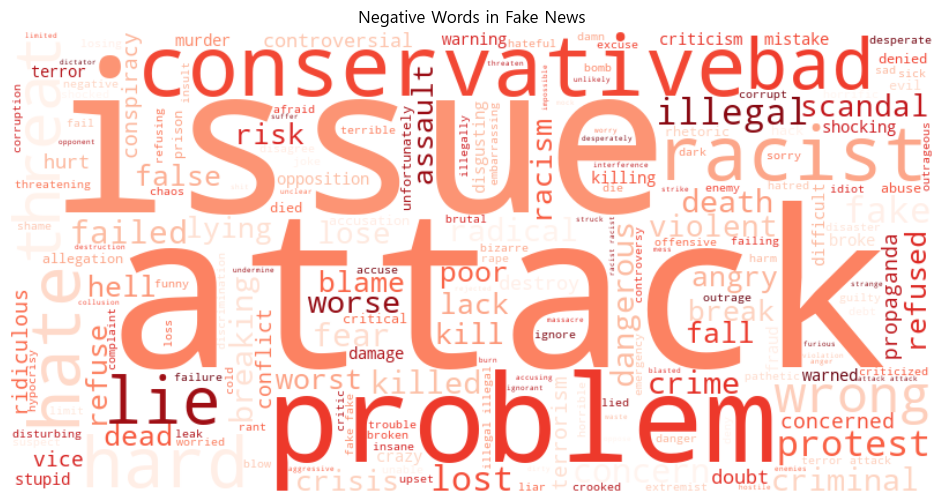

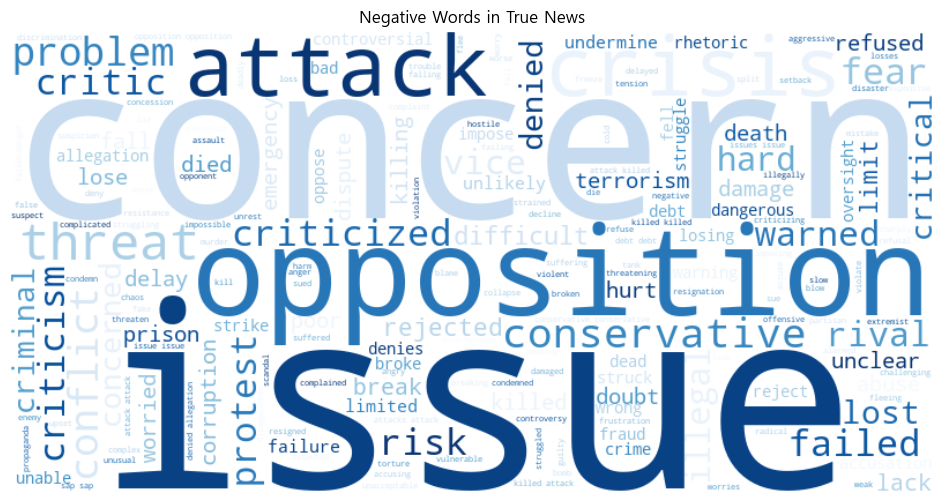

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords
import matplotlib.font_manager as fm

plt.rcParams['font.family'] = 'Malgun Gothic'  # Windows 기본 한글 폰트
plt.rcParams['axes.unicode_minus'] = False     # 마이너스 기호 깨짐 방지

# 부정적인 단어 텍스트 결합(가짜뉴스)
fake_news_negative_words_combined = ' '.join(fake_news_negative_words)

# 워드클라우드 생성
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='Reds'
).generate(fake_news_negative_words_combined)

# 시각화
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Negative Words in Fake News')
plt.show()


# 부정적인 단어 텍스트 결합(진짜뉴스)
true_news_negative_words_combined = ' '.join(true_news_negative_words)

# 워드클라우드 생성
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='Blues'
).generate(true_news_negative_words_combined)

# 시각화
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Negative Words in True News')
plt.show()


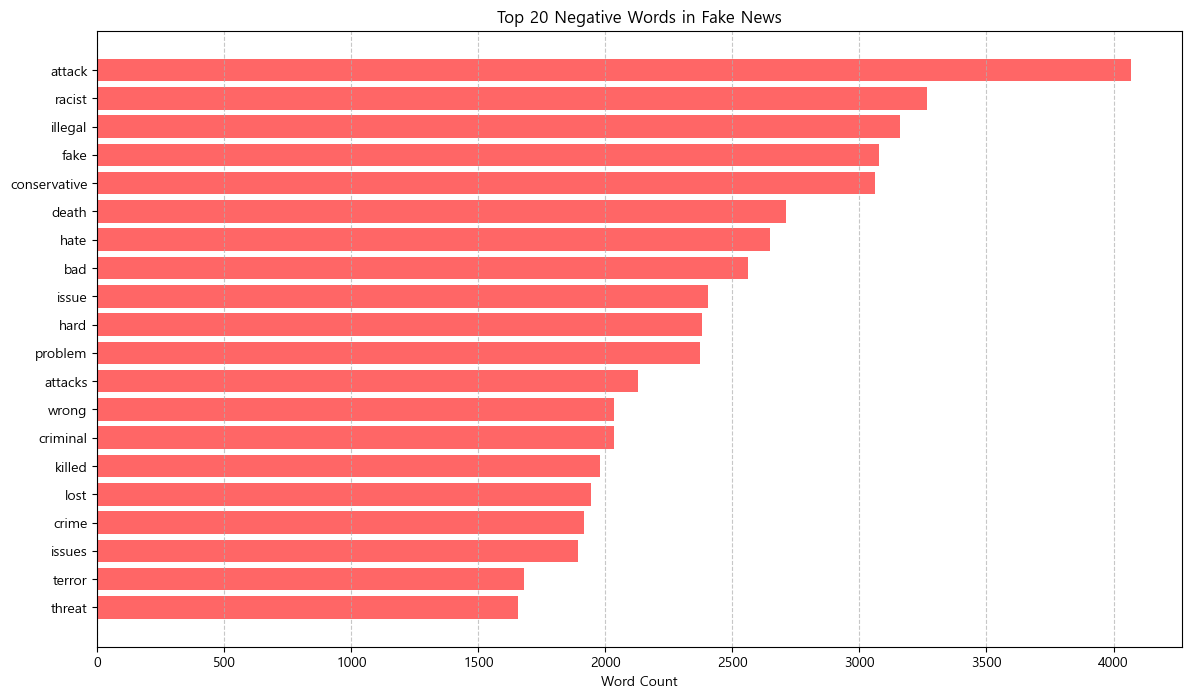

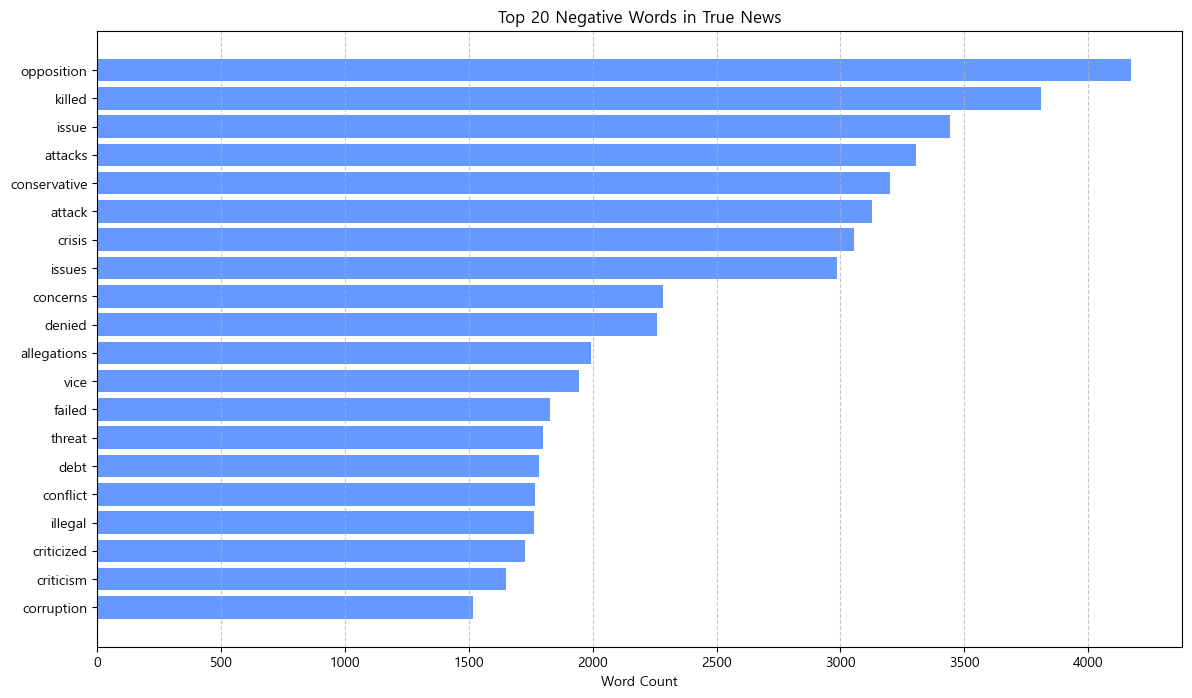

In [13]:
# 가짜 뉴스의 부정 상위 단어 추출
top20_fake_news_negative_words = fake_news_negative_frequency.most_common(20)

# 단어와 빈도 리스트로 분리
if top20_fake_news_negative_words:
    words, counts = zip(*top20_fake_news_negative_words)
    words = list(words)
    counts = list(counts)
    
# 막대그래프 시각화
plt.figure(figsize=(14, 8))
plt.barh(words, counts, color='#ff6666')
plt.title('Top 20 Negative Words in Fake News')
plt.xlabel('Word Count')
plt.gca().invert_yaxis() # y축 위에서 아래로 작아지는 방향
plt.grid(axis='x', linestyle='--', alpha=0.7) # x축 점선 
plt.show()

# 진짜 뉴스의 부정 상위 단어 추출
top20_true_news_negative_words = true_news_negative_frequency.most_common(20)

# 단어와 빈도 리스트로 분리
if top20_true_news_negative_words:
    words, counts = zip(*top20_true_news_negative_words)
    words = list(words)
    counts = list(counts)
    
# 막대그래프 시각화
plt.figure(figsize=(14, 8))
plt.barh(words, counts, color='#6699ff')
plt.title('Top 20 Negative Words in True News')
plt.xlabel('Word Count')
plt.gca().invert_yaxis() # y축 위에서 아래로 작아지는 방향
plt.grid(axis='x', linestyle='--', alpha=0.7) # x축 점선 
plt.show()



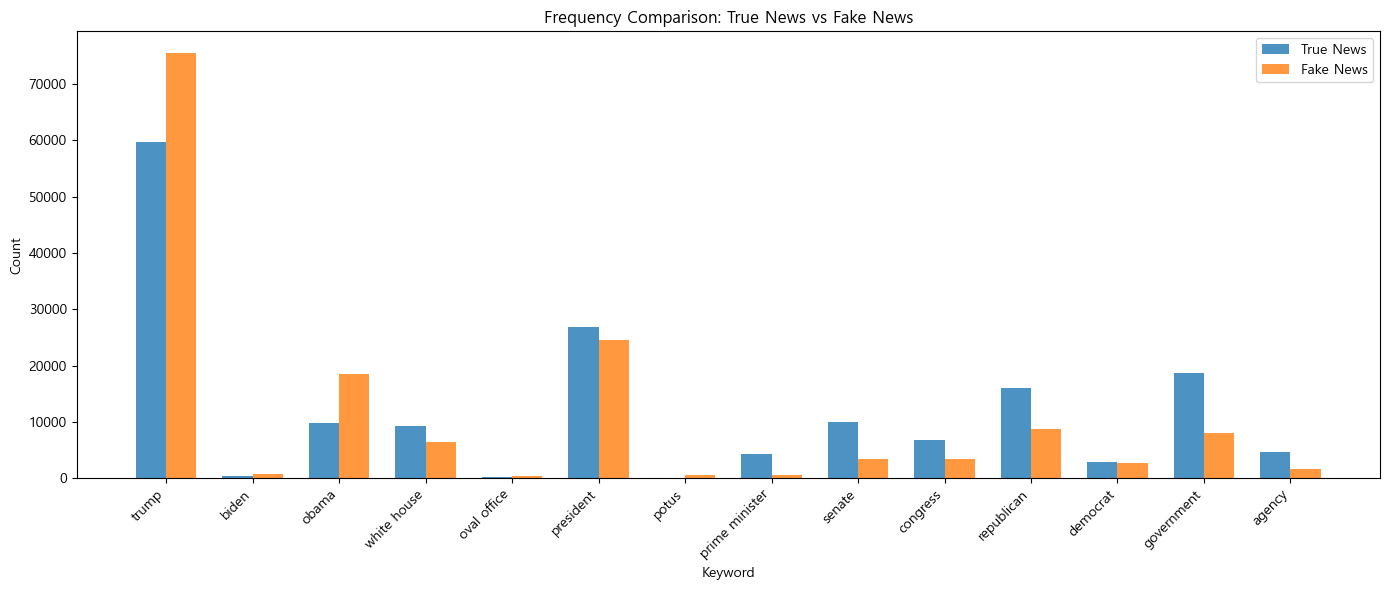

In [14]:
# 키워드 리스트 'presidential_news','political_news'
keywords = [
    'trump', 'biden', 'obama', 'white house', 'oval office', 'president', 'potus',
    'prime minister', 'senate', 'congress', 'republican', 'democrat', 'government', 'agency'
]

true_tokens = word_tokenize(true_news.lower())
fake_tokens = word_tokenize(fake_news.lower())

# 단일 단어 키워드는 Counter로, 복합어(white house 등)는 count로 처리
true_counter = Counter(true_tokens)
fake_counter = Counter(fake_tokens)

def keyword_count(tokens, counter, kw):
    if ' ' in kw:
        # 복합어(예: 'white house')는 전체 텍스트에서 count
        return ' '.join(tokens).count(kw)
    else:
        return counter[kw]

true_news_keywords_counts = {kw: keyword_count(true_tokens, true_counter, kw) for kw in keywords}
fake_news_keywords_counts = {kw: keyword_count(fake_tokens, fake_counter, kw) for kw in keywords}

# 데이터프레임 정리
df_frequency = pd.DataFrame({
    'Keyword': keywords,
    'True News Count': [true_news_keywords_counts[kw] for kw in keywords],
    'Fake News Count': [fake_news_keywords_counts[kw] for kw in keywords]
})


# 키워드 목록과 인덱스
keywords = df_frequency['Keyword']
x = np.arange(len(keywords))  # x축 위치
width = 0.35  # 막대 너비

# 그래프 생성
fig, ax = plt.subplots(figsize=(14, 6))
rects1 = ax.bar(x - width/2, df_frequency['True News Count'], width, label='True News', alpha=0.8)
rects2 = ax.bar(x + width/2, df_frequency['Fake News Count'], width, label='Fake News', alpha=0.8)
    
# 텍스트 및 스타일 설정
ax.set_title('Frequency Comparison: True News vs Fake News')
ax.set_xlabel('Keyword')
ax.set_ylabel('Count')
ax.set_xticks(x)
ax.set_xticklabels(keywords, rotation=45, ha='right')
ax.legend()

plt.tight_layout()
plt.show()


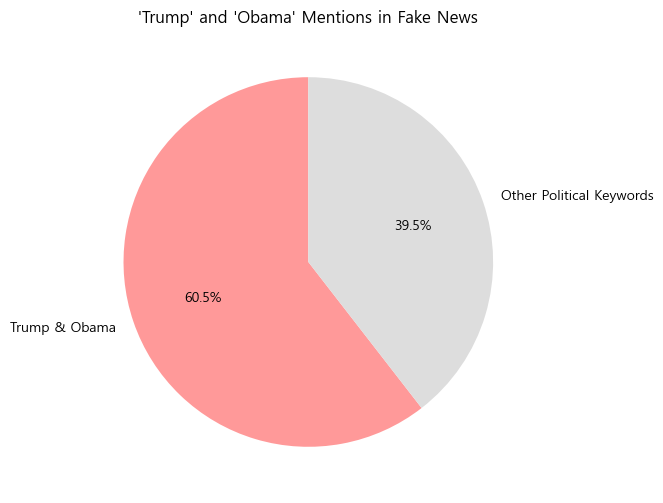

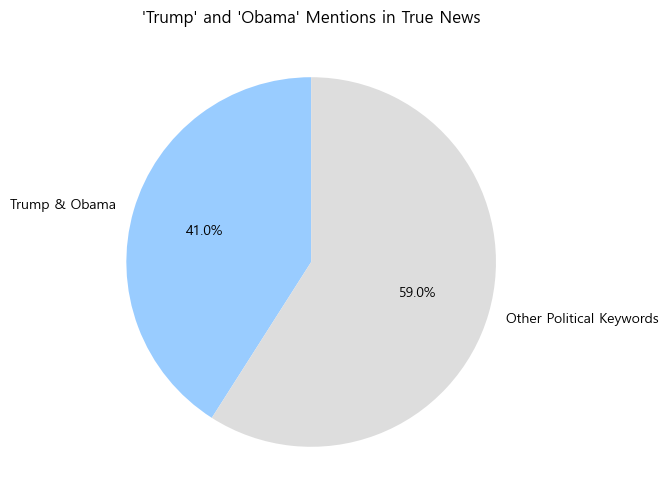

In [15]:
# 관심 있는 키워드
person_keywords = ['trump', 'obama']

# 1. 가짜 뉴스 내 trump, obama
fake_news_person_total = sum(fake_news_keywords_counts[kw] for kw in person_keywords)

# 2. 가짜 뉴스 내 다른 정치 키워드
fake_news_total = sum(fake_news_keywords_counts[kw] for kw in keywords)

# 3. 진짜 뉴스 내 trump, obama
true_news_person_total = sum(true_news_keywords_counts[kw] for kw in person_keywords)

# 4. 진짜 뉴스 내 다른 정치 키워드
true_news_total = sum(true_news_keywords_counts[kw] for kw in keywords)


labels = ['Trump & Obama', 'Other Political Keywords']
sizes = [fake_news_person_total, fake_news_total - fake_news_person_total]

plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=['#ff9999', '#dddddd'])  
plt.title("'Trump' and 'Obama' Mentions in Fake News")
plt.show()

labels = ['Trump & Obama', 'Other Political Keywords']
sizes = [true_news_person_total, true_news_total - true_news_person_total]

plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=['#99ccff', '#dddddd'])
plt.title("'Trump' and 'Obama' Mentions in True News")
plt.show()



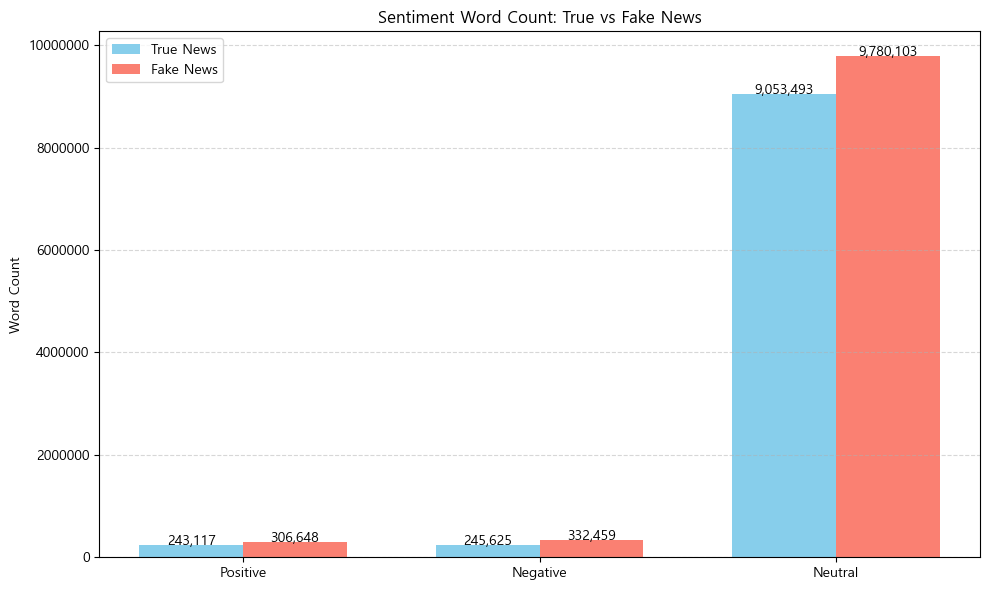

In [16]:
# 감정 단어 수 계산
def sentiment_counts(text):
    tokens = word_tokenize(text.lower())
    total = len(tokens)
    pos = sum(1 for w in tokens if w in positive_words)
    neg = sum(1 for w in tokens if w in negative_words)
    neutral = total - pos - neg
    return pos, neg, neutral

true_pos, true_neg, true_neutral = sentiment_counts(true_news)
fake_pos, fake_neg, fake_neutral = sentiment_counts(fake_news)

# 범주별 데이터
categories = ['Positive', 'Negative', 'Neutral']
true_counts = [true_pos, true_neg, true_neutral]
fake_counts = [fake_pos, fake_neg, fake_neutral]

# 그룹형 막대그래프
x = np.arange(len(categories))
width = 0.35

plt.figure(figsize=(10, 6))
plt.bar(x - width/2, true_counts, width, label='True News', color='skyblue')
plt.bar(x + width/2, fake_counts, width, label='Fake News', color='salmon')

# 값 표시
for i in range(len(categories)):
    plt.text(x[i] - width/2, true_counts[i] + 1000, f'{true_counts[i]:,}', ha='center', fontsize=10)
    plt.text(x[i] + width/2, fake_counts[i] + 1000, f'{fake_counts[i]:,}', ha='center', fontsize=10)

plt.xticks(x, categories)
plt.ylabel('Word Count')
plt.title('Sentiment Word Count: True vs Fake News')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.ticklabel_format(style='plain', axis='y')
plt.tight_layout()
plt.show()


In [17]:
#감성분석 & 주제 관련 변수 추가

def sentiment_features(text):
    tokens = word_tokenize(text.lower())
    total = len(tokens)
    pos_words = [w for w in tokens if w in positive_words]
    neg_words = [w for w in tokens if w in negative_words]
    pos = len(pos_words)
    neg = len(neg_words)
    polarity = (pos - neg) / total if total else 0
    pos_neg_ratio = pos / (neg + 1)
    unique_pos = len(set(pos_words))
    unique_neg = len(set(neg_words))
    max_pos_freq = Counter(pos_words).most_common(1)[0][1] if pos_words else 0
    max_neg_freq = Counter(neg_words).most_common(1)[0][1] if neg_words else 0
    president_count = sum(1 for w in tokens if w in person_keywords)  
    president_ratio = president_count / total if total else 0  
    return pd.Series([pos, neg, polarity, pos_neg_ratio, unique_pos, unique_neg, max_pos_freq, max_neg_freq, president_ratio])



In [18]:
totalnews_df[['pos_count', 'neg_count', 'polarity_score', 'pos_neg_ratio','unique_positive_count', 'unique_negative_count',
    'max_positive_freq', 'max_negative_freq', 'president_ratio']] = totalnews_df['text'].apply(sentiment_features)

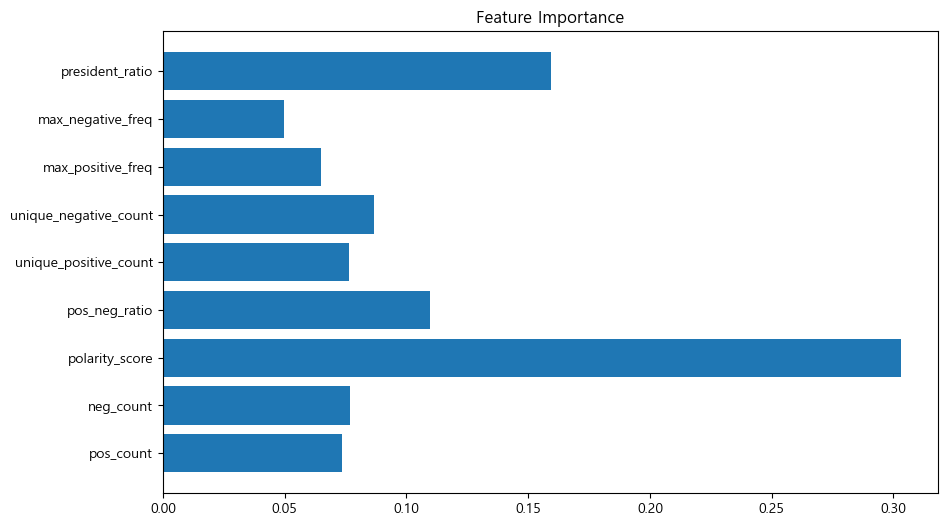

In [19]:
#감성분석의 변수들의 모델 내 중요도 분석
#RandomForest : 변수 중요도 내장된 feature_importances_ 속성으로 각 변수의 기여도를 정량화합니다, 
# 앙상블 기법으로 과적합을 방지하며, 다양한 데이터 유형에 잘 적용됩니다.
# 비선형 관계 포착: 트리 기반 모델이기 때문에 변수 간 복잡한 상호작용을 모델링할 수 있습니다
#2. 변수 중요도 계산 방법
# 불순도 감소 기준: 각 분할에서 변수가 불순도(지니/엔트로피)를 얼마나 감소시켰는지 누적하여 계산합니다.
# 정규화: 모든 트리에서의 평균 불순도 감소량을 정규화해 중요도를 0~1 사이로 표현합니다.
from sklearn.ensemble import RandomForestClassifier

# X는 감성 변수만 있는 데이터프레임
X = totalnews_df[['pos_count', 'neg_count', 'polarity_score', 
                  'pos_neg_ratio', 'unique_positive_count', 
                  'unique_negative_count', 'max_positive_freq', 
                  'max_negative_freq','president_ratio']]
y = totalnews_df['label']

model = RandomForestClassifier()
model.fit(X, y)

# 변수 중요도 시각화
plt.figure(figsize=(10, 6))
plt.barh(X.columns, model.feature_importances_)
plt.title('Feature Importance')
plt.show()

#중요도 0.05제거 : 의미없는 변수의 하향선 ==> 감성분석 변수 모두 유효 --> 그대로 진행

In [20]:
from sklearn.model_selection import train_test_split

def split_data(totalnews_df, test_size=0.2, random_state=42):
    """전체 데이터프레임을 train/test로 분할 (인덱스 보장)"""
    train_df, test_df = train_test_split(
        totalnews_df,
        test_size=test_size,
        random_state=random_state,
        stratify=totalnews_df['label']
    )
    print(f"▶ Train set 크기: {len(train_df)}")
    print(f"▶ Test set 크기: {len(test_df)}")
    return train_df, test_df

train_df, test_df = split_data(totalnews_df)

▶ Train set 크기: 34267
▶ Test set 크기: 8567


In [21]:
#숫자형 변수(감성 분석) 표준화 진행
#정규화 vs 표준화 = 0~1사이의 값으로 vs 평균 0, 표준편차 1로 맞추기
#우리 데이터에는 음수부터 30대의 다양한 값 + 소수점까지 너무 다양한 값 ==> 정규화보단 표준화가 다양한 유형의 값 처리 가능
from sklearn.preprocessing import StandardScaler

# 표준화할 감성 변수 리스트
sentiment_features_word = [
    'pos_count', 'neg_count', 'polarity_score', 'pos_neg_ratio',
    'unique_positive_count', 'unique_negative_count',
    'max_positive_freq', 'max_negative_freq','president_ratio'
]

# 1. StandardScaler 객체 생성
scaler = StandardScaler()

# 2. 표준화 적용 (전체 데이터프레임에 적용 예시)
train_df[sentiment_features_word] = scaler.fit_transform(train_df[sentiment_features_word])
test_df[sentiment_features_word] = scaler.transform(test_df[sentiment_features_word])


In [22]:
from transformers import AutoTokenizer, AutoModel
import torch
from tqdm import tqdm
import numpy as np

# 사전학습된 BERT 모델 불러오기 (GPU 사용 가능 시 자동 전환)
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModel.from_pretrained("bert-base-uncased")
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)  # 모델을 GPU로 이동

def extract_cls_embedding(text_list, batch_size=32):  # 배치 크기 기본값 32
    text_list = [str(text) for text in text_list]
    cls_embeddings = []

    # 배치 단위 처리
    for i in tqdm(range(0, len(text_list), batch_size), desc="BERT 임베딩 생성"):
        batch = text_list[i:i+batch_size]

        # 1. 텍스트 토큰화 (배치 처리)
        inputs = tokenizer(
            batch,
            return_tensors="pt",
            truncation=True,
            padding=True,  # 배치 처리 시 필수
            max_length=512
        ).to(device)  # 입력 데이터도 GPU로 이동

        # 2. BERT에 입력 → 출력 벡터 얻기
        with torch.no_grad():
            outputs = model(**inputs)
            last_hidden = outputs.last_hidden_state  # [batch_size, seq_len, 768]

            # 3. [CLS] 벡터 추출 (첫 번째 토큰 위치)
            cls_vectors = last_hidden[:, 0, :]  # [batch_size, 768]

        # 4. numpy 변환 및 리스트 저장 (CPU로 이동)
        cls_embeddings.extend(cls_vectors.cpu().numpy())

    return np.array(cls_embeddings)


In [23]:
import pandas as pd
import os

def save_load_embeddings(train_df, test_df):
    """제목/본문 임베딩 생성 또는 기존 파일 로드"""
    # 파일 경로 설정
    paths = {
        'train_title': 'X_train_title_bert.npy',
        'train_text': 'X_train_text_bert.npy',
        'test_title': 'X_test_title_bert.npy',
        'test_text': 'X_test_text_bert.npy'
    }
    results = {}
    if os.path.exists(paths['train_title']):
        print("▶ Train 제목 임베딩 파일 로드")
        X_train_title = np.load(paths['train_title'])
    else:
        print("▶ Train 제목 임베딩 생성 시작")
        X_train_title = extract_cls_embedding(train_df['cleaned_title'].tolist())
        np.save(paths['train_title'], X_train_title)
        print(f"  저장 완료: {paths['train_title']}")
    results['train_title'] = X_train_title

    # 2. Train Text 임베딩
    if os.path.exists(paths['train_text']):
        print("▶ Train 본문 임베딩 파일 로드")
        X_train_text = np.load(paths['train_text'])
    else:
        print("▶ Train 본문 임베딩 생성 시작")
        X_train_text = extract_cls_embedding(train_df['cleaned_text'].tolist())
        np.save(paths['train_text'], X_train_text)
        print(f"  저장 완료: {paths['train_text']}")
    results['train_text'] = X_train_text

    # 3. Test Title 임베딩
    if os.path.exists(paths['test_title']):
        print("▶ Test 제목 임베딩 파일 로드")
        X_test_title = np.load(paths['test_title'])
    else:
        print("▶ Test 제목 임베딩 생성 시작")
        X_test_title = extract_cls_embedding(test_df['cleaned_title'].tolist())
        np.save(paths['test_title'], X_test_title)
        print(f"  저장 완료: {paths['test_title']}")
    results['test_title'] = X_test_title

    # 4. Test Text 임베딩
    if os.path.exists(paths['test_text']):
        print("▶ Test 본문 임베딩 파일 로드")
        X_test_text = np.load(paths['test_text'])
    else:
        print("▶ Test 본문 임베딩 생성 시작")
        X_test_text = extract_cls_embedding(test_df['cleaned_text'].tolist())
        np.save(paths['test_text'], X_test_text)
        print(f"  저장 완료: {paths['test_text']}")
    results['test_text'] = X_test_text
    
    
    # 결합해서 반환
    X_train_combined = np.concatenate([results['train_title'], results['train_text']], axis=1)
    X_test_combined = np.concatenate([results['test_title'], results['test_text']], axis=1)
    return X_train_combined, X_test_combined

# 2. 임베딩 생성/로드
X_train_combined, X_test_combined = save_load_embeddings(train_df, test_df)
    
# 3. 결과 확인
print("\n✔ 최종 임베딩 차원")
print(f"Train: {X_train_combined.shape}")
print(f"Test: {X_test_combined.shape}") 

▶ Train 제목 임베딩 파일 로드
▶ Train 본문 임베딩 파일 로드
▶ Test 제목 임베딩 생성 시작


BERT 임베딩 생성: 100%|██████████| 268/268 [02:29<00:00,  1.80it/s]


  저장 완료: X_test_title_bert.npy
▶ Test 본문 임베딩 생성 시작


BERT 임베딩 생성: 100%|██████████| 268/268 [44:08<00:00,  9.88s/it]


  저장 완료: X_test_text_bert.npy

✔ 최종 임베딩 차원
Train: (34267, 1536)
Test: (8567, 1536)


In [24]:
#BERT 임베딩 파일(배열 형태)과 표준화된 감성 변수(데이터 프레임 내에 Numpy 배열로 존재) 결합하는 최종 결합 코드
# BERT 임베딩 + 감성 변수 결합
X_train_final = np.concatenate(
    [X_train_combined, train_df[sentiment_features_word].values], 
    axis=1
)
X_test_final = np.concatenate(
    [X_test_combined, test_df[sentiment_features_word].values], 
    axis=1
)

# 레이블 추출
y_train = train_df['label'].values
y_test = test_df['label'].values 

In [25]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
import time

#1. 5-Fold 교차검증
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Linear SVM": LinearSVC(),
    "Random Forest": RandomForestClassifier(),
    "Naive Bayes": GaussianNB(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "XGBoost": XGBClassifier(eval_metric='logloss')
}

print("\n" + "="*50)
print("5-Fold 교차검증 결과")
print("="*50)

cv_results = {}
for name, model in models.items():
    scores = cross_validate(
        model,
        X_train_final,
        y_train,  
        cv=5,
        scoring=['accuracy', 'precision', 'recall', 'f1'],
        n_jobs=1  
    )
    cv_results[name] = {
        'Accuracy': f"{np.mean(scores['test_accuracy']):.4f}",
        'Precision': f"{np.mean(scores['test_precision']):.4f}",
        'Recall': f"{np.mean(scores['test_recall']):.4f}",
        'F1-score': f"{np.mean(scores['test_f1']):.4f}",
        'Fit Time (sec)': f"{np.mean(scores['fit_time']):.1f}"
    }

cv_df = pd.DataFrame(cv_results).T
print(cv_df)



5-Fold 교차검증 결과
                    Accuracy Precision  Recall F1-score Fit Time (sec)
Logistic Regression   0.9971    0.9969  0.9974   0.9971            0.9
Linear SVM            0.9969    0.9968  0.9970   0.9969            3.8
Random Forest         0.9799    0.9791  0.9807   0.9799          146.7
Naive Bayes           0.9353    0.9247  0.9479   0.9361            0.6
Gradient Boosting     0.9817    0.9791  0.9845   0.9818         1731.4
XGBoost               0.9913    0.9897  0.9930   0.9913           16.3


In [26]:
# 2. 테스트셋 평가 
print("\n" + "="*50)
print("테스트셋 최종 평가 결과")
print("="*50)

results = []
for name, model in models.items():
    start_time = time.time()
    model.fit(X_train_final, y_train)
    train_time = time.time() - start_time
    
    y_pred = model.predict(X_test_final)
    
    results.append({
        'Model': name,
        'Accuracy': f"{accuracy_score(y_test, y_pred):.4f}",
        'Precision': f"{precision_score(y_test, y_pred):.4f}",
        'Recall': f"{recall_score(y_test, y_pred):.4f}",
        'F1-score': f"{f1_score(y_test, y_pred):.4f}",
        'Test Time (sec)': f"{train_time:.1f}"
    })

results_df = pd.DataFrame(results)
print(results_df)


테스트셋 최종 평가 결과
                 Model Accuracy Precision  Recall F1-score Test Time (sec)
0  Logistic Regression   0.9967    0.9967  0.9967   0.9967             1.2
1           Linear SVM   0.9971    0.9972  0.9970   0.9971             6.0
2        Random Forest   0.9830    0.9830  0.9830   0.9830           306.4
3          Naive Bayes   0.9380    0.9285  0.9491   0.9387             0.8
4    Gradient Boosting   0.9830    0.9798  0.9862   0.9830          2385.1
5              XGBoost   0.9921    0.9907  0.9935   0.9921            23.4


In [38]:
# 3. 혼돈 행렬 출력 (Logistic Regression 기준) 
LogisticRegression_model = models["Logistic Regression"].fit(X_train_final, y_train)
y_pred = LogisticRegression_model.predict(X_test_final)
print("\n" + "="*50)
print("LogisticRegression 혼동 행렬")
print("="*50)
print(confusion_matrix(y_test, y_pred))


LogisticRegression 혼동 행렬
[[4270   14]
 [  14 4269]]


In [ ]:
from sklearn.linear_model import LogisticRegression
import joblib

# 1. 최적 모델 선정 (Logistic Regression)
final_model = LogisticRegression(max_iter=1000)
final_model.fit(X_train_final, y_train)

# 2. 모델 저장
joblib.dump(final_model, "logreg_model.pkl")

# 3. Scaler 저장 (감성 변수 표준화에 사용)
joblib.dump(scaler, "scaler.pkl")


['scaler.pkl']

In [ ]:
# FastAPI 기반 데모: 기존 Jupyter 함수와 변수 재사용 버전
from fastapi import FastAPI, HTTPException
from pydantic import BaseModel

app = FastAPI()
# 전처리 및 감성 피처 관련 전역 변수와 함수는 이미 위에서 정의되었으므로 재사용
# tokenizer, device는 이미 정의되었음을 가정하고, bert_model 정의만 추가
bert_model = AutoModel.from_pretrained("bert-base-uncased")
bert_model.eval()
bert_model = bert_model.to(device)

# 단건 임베딩 함수만 정의
def extract_single_bert_embedding(text: str):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512).to(device)
    with torch.no_grad():
        outputs = bert_model(**inputs)
        cls_vector = outputs.last_hidden_state[:, 0, :]  # [1, 768]
    return cls_vector.cpu().numpy()

# ------------------------- 모델 및 API ----------------------------
import joblib

model = joblib.load("logreg_model.pkl")
scaler = joblib.load("scaler.pkl")

class NewsRequest(BaseModel):
    title: str
    text: str

class PredictResponse(BaseModel):
    is_fake: bool
    probability: float
    model: str

@app.post("/predict", response_model=PredictResponse)
async def predict(news: NewsRequest):
    try:
        cleaned_title = process_text(news.title)
        cleaned_text = process_text(news.text)

        title_vec = extract_single_bert_embedding(cleaned_title)
        text_vec = extract_single_bert_embedding(cleaned_text)
        combined_vec = np.concatenate([title_vec, text_vec], axis=1)  # (1, 1536)

        senti_vec = sentiment_features(cleaned_title + " " + cleaned_text).values.reshape(1, -1)
        scaled_senti = scaler.transform(senti_vec)

        full_input = np.concatenate([combined_vec, scaled_senti], axis=1)  # (1, 1545)

        prediction = model.predict(full_input)
        proba = model.predict_proba(full_input)[0]

        return PredictResponse(
            is_fake=bool(prediction[0] == 0),
            probability=float(proba[prediction[0]]),
            model="Logistic Regression (Accuracy: 99.67%, Mean : 99.67%)"
        )
    except Exception as e:
        raise HTTPException(status_code=500, detail=str(e))

@app.get("/")
async def health_check():
    return {"status": "OK", "model": "Logistic Regression + BERT"}

# ------------------------- Jupyter 전용 실행 트리거 ----------------------------
# 아래 코드는 Jupyter에서 직접 서버를 실행할 때만 필요함
try:
    import nest_asyncio
    import uvicorn
    nest_asyncio.apply()
    print("✅ FastAPI 서버 실행 중: http://localhost:8000")
    uvicorn.run(app, host="0.0.0.0", port=8000)
except Exception as e:
    print("⚠️ FastAPI 서버 실행 실패:", e)


✅ FastAPI 서버 실행 중: http://localhost:8000


INFO:     Started server process [102984]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO:     127.0.0.1:50988 - "GET /docs HTTP/1.1" 200 OK
INFO:     127.0.0.1:50988 - "GET /openapi.json HTTP/1.1" 200 OK
INFO:     127.0.0.1:50991 - "POST /predict HTTP/1.1" 200 OK


c:\Users\JinsuRoh\anaconda3\envs\tfenvJS\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


INFO:     127.0.0.1:51056 - "POST /predict HTTP/1.1" 422 Unprocessable Entity
INFO:     127.0.0.1:51057 - "POST /predict HTTP/1.1" 200 OK


c:\Users\JinsuRoh\anaconda3\envs\tfenvJS\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


INFO:     127.0.0.1:51068 - "POST /predict HTTP/1.1" 422 Unprocessable Entity
INFO:     127.0.0.1:51069 - "POST /predict HTTP/1.1" 200 OK


c:\Users\JinsuRoh\anaconda3\envs\tfenvJS\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


INFO:     127.0.0.1:51076 - "POST /predict HTTP/1.1" 200 OK


c:\Users\JinsuRoh\anaconda3\envs\tfenvJS\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


INFO:     127.0.0.1:51095 - "POST /predict HTTP/1.1" 200 OK


c:\Users\JinsuRoh\anaconda3\envs\tfenvJS\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
INFO:     Shutting down
INFO:     Waiting for application shutdown.
INFO:     Application shutdown complete.
INFO:     Finished server process [102984]


향후 해결해야할 문제 1. 하이퍼파리미터 튜닝